In [1]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications.efficientnet import preprocess_input

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import itertools


In [2]:
from google.colab import files
import zipfile
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

TRAIN_DIR = '/content/drive/MyDrive/ACD/DATASET/train'
TEST_DIR  = '/content/drive/MyDrive/ACD/DATASET/test'

IMG_SIZE = (260, 260)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE


In [5]:

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 1248 files belonging to 3 classes.
Using 999 files for training.
Found 1248 files belonging to 3 classes.
Using 249 files for validation.
Found 312 files belonging to 3 classes.
Classes: ['Aedes aegypti', 'Aedes albopictus', 'Culex quinquefasciatus']


In [6]:

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.3),
], name="data_augmentation")


In [7]:

def prepare(ds, training=False):
    def _map(x, y):
        x = tf.image.resize(x, IMG_SIZE)
        x = tf.cast(x, tf.float32)
        if training:
            x = data_augmentation(x, training=True)
        x = preprocess_input(x)
        return x, y

    ds = ds.map(_map, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(1000)
    return ds.prefetch(AUTOTUNE)

train_ds_prep = prepare(train_ds, training=True)
val_ds_prep   = prepare(val_ds, training=False)
test_ds_prep  = prepare(test_ds, training=False )


In [8]:

base_model = EfficientNetB2(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)

base_model.trainable = False

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb2 (Functional)     │ (None, 9, 9, 1408)     │     7,768,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         4,227 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,772,796 (29.65 MB)

 Trainable params: 4,227 (16.51 KB)

 Non-trainable params: 7,768,569 (29.63 MB)

In [9]:

best_path = "/content/drive/MyDrive/ACD/Model/best_model_efficienetb2.keras"

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=best_path,
        monitor="val_loss",
        save_best_only=True,
        mode="min"
    )
]

In [25]:

history_fe = model.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs= 20,
    callbacks=callbacks
)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 371s 5s/step - accuracy: 0.7327 - loss: 0.6377 - val_accuracy: 0.8715 - val_loss: 0.3121
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 329s 4s/step - accuracy: 0.7430 - loss: 0.6032 - val_accuracy: 0.8434 - val_loss: 0.3596
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 385s 4s/step - accuracy: 0.7481 - loss: 0.5393 - val_accuracy: 0.8313 - val_loss: 0.3825
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 375s 4s/step - accuracy: 0.7399 - loss: 0.5758 - val_accuracy: 0.8353 - val_loss: 0.3932
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 386s 4s/step - accuracy: 0.7575 - loss: 0.6029 - val_accuracy: 0.8394 - val_loss: 0.3972
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 375s 5s/step - accuracy: 0.7274 - loss: 0.5784 - val_accuracy: 0.8434 - val_loss: 0.3951


In [12]:

test_loss, test_acc = model.evaluate(test_ds_prep)
print("Test Accuracy:", test_acc)


20/20 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.8959 - loss: 0.2554
Test Accuracy: 0.9070512652397156


20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step
Classification report:
                         precision    recall  f1-score   support

         Aedes aegypti       0.89      0.85      0.87       104
      Aedes albopictus       0.88      0.88      0.88       104
Culex quinquefasciatus       0.94      0.99      0.97       104

              accuracy                           0.91       312
             macro avg       0.91      0.91      0.91       312
          weighted avg       0.91      0.91      0.91       312

Confusion matrix:
 [[ 88  12   4]
 [ 10  92   2]
 [  1   0 103]]


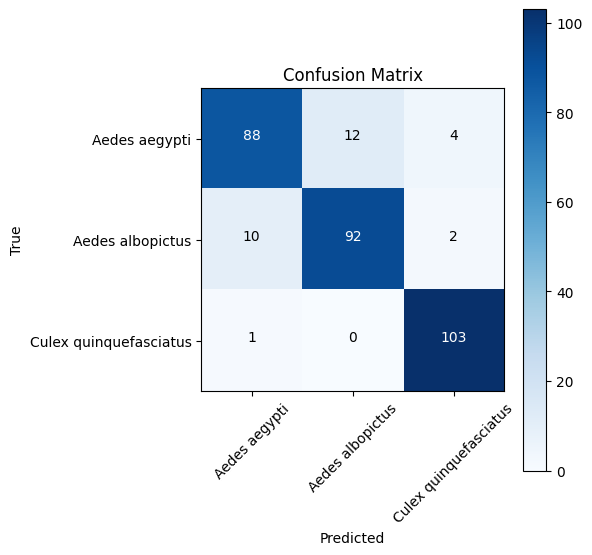

In [13]:

y_true = np.concatenate([y.numpy() for _, y in test_ds_prep], axis=0)
y_pred_probs = model.predict(test_ds_prep)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
print('Classification report:\n', classification_report(y_true, y_pred, target_names=class_names))
print('Confusion matrix:\n', cm)

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(6,6))
    plt.imshow(cm, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45)
    plt.yticks(ticks, classes)
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], ha="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, class_names)


In [15]:
# Akurasi training per epoch
train_acc = history_ft.history['accuracy']

# Akurasi validasi per epoch
val_acc = history_ft.history['val_accuracy']

# Loss training per epoch
train_loss = history_ft.history['loss']

# Loss validasi per epoch
val_loss = history_ft.history['val_loss']

In [16]:
for i in range(len(train_acc)):
    print(f"Epoch {i+1}: "
          f"Train Acc = {train_acc[i]:.4f}, "
          f"Val Acc = {val_acc[i]:.4f}, "
          f"Train Loss = {train_loss[i]:.4f}, "
          f"Val Loss = {val_loss[i]:.4f}")

Epoch 1: Train Acc = 0.7117, Val Acc = 0.8715, Train Loss = 0.6154, Val Loss = 0.2517
Epoch 2: Train Acc = 0.7317, Val Acc = 0.8755, Train Loss = 0.5907, Val Loss = 0.3126
Epoch 3: Train Acc = 0.7357, Val Acc = 0.8474, Train Loss = 0.6082, Val Loss = 0.3578
Epoch 4: Train Acc = 0.7447, Val Acc = 0.8273, Train Loss = 0.5956, Val Loss = 0.3830
Epoch 5: Train Acc = 0.7628, Val Acc = 0.8313, Train Loss = 0.5543, Val Loss = 0.3936
Epoch 6: Train Acc = 0.7818, Val Acc = 0.8353, Train Loss = 0.5247, Val Loss = 0.3950


In [17]:
for i in range(len(train_acc)):
    gap = train_acc[i] - val_acc[i]
    print(f"Epoch {i+1}: "
          f"Train Acc = {train_acc[i]:.4f}, "
          f"Val Acc = {val_acc[i]:.4f}, "
          f"Gap = {gap:.4f}")

Epoch 1: Train Acc = 0.7117, Val Acc = 0.8715, Gap = -0.1598
Epoch 2: Train Acc = 0.7317, Val Acc = 0.8755, Gap = -0.1438
Epoch 3: Train Acc = 0.7357, Val Acc = 0.8474, Gap = -0.1117
Epoch 4: Train Acc = 0.7447, Val Acc = 0.8273, Gap = -0.0826
Epoch 5: Train Acc = 0.7628, Val Acc = 0.8313, Gap = -0.0686
Epoch 6: Train Acc = 0.7818, Val Acc = 0.8353, Gap = -0.0536


In [18]:
# cek apakah history_ft ada dan apa isinya
print(type(history_ft))
print(dir(history_ft))
print(history_ft.history.keys())

<class 'keras.src.callbacks.history.History'>
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_api_export_path', '_api_export_symbol_id', '_model', 'epoch', 'history', 'model', 'on_batch_begin', 'on_batch_end', 'on_epoch_begin', 'on_epoch_end', 'on_predict_batch_begin', 'on_predict_batch_end', 'on_predict_begin', 'on_predict_end', 'on_test_batch_begin', 'on_test_batch_end', 'on_test_begin', 'on_test_end', 'on_train_batch_begin', 'on_train_batch_end', 'on_train_begin', 'on_train_end', 'params', 'set_model', 'set_params']
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [22]:
import numpy as np
import pandas as pd

img_path = '/content/drive/MyDrive/ACD/DATASET/testingdata/testing1.jpg'

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(260, 260))
img_array = tf.keras.preprocessing.image.img_to_array(img)

# Preprocessing
img_array = preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)[0]

# Ambil prediksi kelas
predicted_class = class_names[np.argmax(prediction)]

# Buat tabel probabilitas
df = pd.DataFrame({
    "Class": class_names,
    "Probability (%)": np.round(prediction * 100, 2)
})

# Urutkan dari probability tertinggi
df = df.sort_values(by="Probability (%)", ascending=False).reset_index(drop=True)

print("Hasil Prediksi:")
print("---------------")
print(f"Prediksi Utama: {predicted_class}\n")
print(df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Hasil Prediksi:
---------------
Prediksi Utama: Aedes aegypti

                    Class  Probability (%)
0           Aedes aegypti        54.119999
1        Aedes albopictus        45.730000
2  Culex quinquefasciatus         0.150000


In [23]:
import numpy as np
import pandas as pd

img_path = '/content/drive/MyDrive/ACD/DATASET/testingdata/testing2.jpg'

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(260, 260))
img_array = tf.keras.preprocessing.image.img_to_array(img)

# Preprocessing
img_array = preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)[0]

# Ambil prediksi kelas
predicted_class = class_names[np.argmax(prediction)]

# Buat tabel probabilitas
df = pd.DataFrame({
    "Class": class_names,
    "Probability (%)": np.round(prediction * 100, 2)
})

# Urutkan dari probability tertinggi
df = df.sort_values(by="Probability (%)", ascending=False).reset_index(drop=True)

print("Hasil Prediksi:")
print("---------------")
print(f"Prediksi Utama: {predicted_class}\n")
print(df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Hasil Prediksi:
---------------
Prediksi Utama: Aedes aegypti

                    Class  Probability (%)
0           Aedes aegypti        81.599998
1        Aedes albopictus        16.570000
2  Culex quinquefasciatus         1.830000


In [24]:
import numpy as np
import pandas as pd

img_path = '/content/drive/MyDrive/ACD/DATASET/testingdata/testing3.png'

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(260, 260))
img_array = tf.keras.preprocessing.image.img_to_array(img)

# Preprocessing
img_array = preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)[0]

# Ambil prediksi kelas
predicted_class = class_names[np.argmax(prediction)]

# Buat tabel probabilitas
df = pd.DataFrame({
    "Class": class_names,
    "Probability (%)": np.round(prediction * 100, 2)
})

# Urutkan dari probability tertinggi
df = df.sort_values(by="Probability (%)", ascending=False).reset_index(drop=True)

print("Hasil Prediksi:")
print("---------------")
print(f"Prediksi Utama: {predicted_class}\n")
print(df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Hasil Prediksi:
---------------
Prediksi Utama: Culex quinquefasciatus

                    Class  Probability (%)
0  Culex quinquefasciatus        79.860001
1           Aedes aegypti        12.340000
2        Aedes albopictus         7.800000
